In [126]:
import pandas as pd
import os
import school_analysis as sa

path=os.path.join(sa.PROJECT_PATH, "data", "genesis","number_of_repeaters.csv")
df = pd.read_csv(os.path.join(sa.PROJECT_PATH ,path), sep=";", skiprows=5, skipfooter=14, engine="python")

df.replace("b'", "", inplace=True, regex=True)
years = [item for item in df.iloc[1].dropna().tolist() if item!='' and item!='\'']

data = []

for idx, year in enumerate(years):
    repeaters = df.iloc[169:, 1 + 3 * (idx + 1)].dropna().tolist()[:-2]
    classes = df.iloc[169:, 1].dropna().tolist()[:-2]
    
    if len(repeaters) != len(classes):
        raise ValueError("length of 'repeaters' und 'classes' does not match.")

    for cl, rp in zip(classes, repeaters):
        data.append({'class': cl, 'repeaters': rp, 'year': year})


df_melted = pd.DataFrame(data)

df_melted["year"] = df_melted["year"].replace("/.*", "", regex=True).astype(int)


df.set_index("b'Repeaters (number)", inplace=True)


total_repeaters = []

for idx, year in enumerate(list(set(df_melted["year"].values))):
    x = df.tail(1).values.tolist()[0][1:]
    x = int(x[2+3*idx].replace("'",''))
    total_repeaters.append((year,x))

Von Tom kopiert #TODO: Schön machen

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

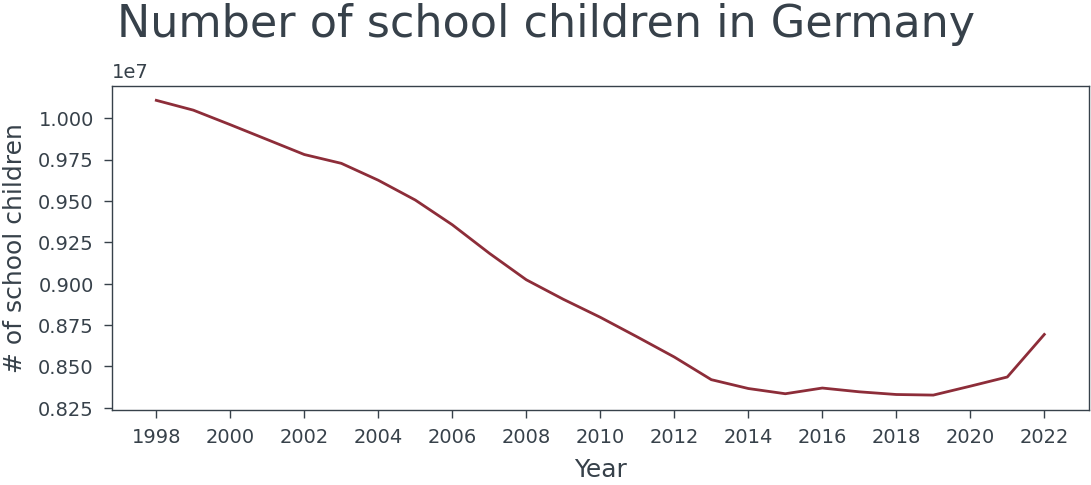

In [127]:
FS_PATH = "data/genesis/school_children_by_state.csv"
SCHOOL_TYPE_PATH = "data/genesis/school_children_by_type.csv"
import pandas as pd
import numpy as np

from operator import index
import warnings

def load_number_childs_fs(path: str = FS_PATH) -> pd.DataFrame:
    """Load table from destatis excel file"""
    df = pd.read_csv(os.path.join(sa.PROJECT_PATH ,path), sep=";", skiprows=5, skipfooter=4, engine="python")
    df.replace("b'", "", inplace=True, regex=True)
    df.rename(columns={"b'": "School Year"}, inplace=True)
    df.rename(columns={"Baden-W\\xc3\\xbcrttemberg": "Baden-Württemberg"}, inplace=True)
    df.rename(columns={"Th\\xc3\\xbcringen": "Thüringen"}, inplace=True)
    
  
    # Generate gender column
    num_years = 26
    male = df.iloc[:num_years + 3].index
    female = df.iloc[num_years + 3:].index
    all = df.iloc[2 * num_years + 4:].index
    df["gender"] = np.nan
    df.iloc[male, -1] = "m"
    df.iloc[female, -1] = "f"
    df.iloc[all, -1] = "all"
    df.drop([1,2,29,56], inplace=True)
    
    # Build own melted table --> may be done better
    temp = pd.DataFrame(columns=["Federal State", "Gender", "Type", "Value", "Year"])
    for col_index in range(1, len(df.columns)-1, 3):
        for index in df.index[1:]:
            year = df.loc[index, "School Year"]
            gender = df.loc[index, "gender"]
            federal_state = df.columns[col_index]
            temp.loc[len(temp)] = [federal_state, gender, "Pupils", df.loc[index][df.columns[col_index]], year]
            temp.loc[len(temp)] = [federal_state, gender, "School beginners", df.loc[index][df.columns[col_index + 1]], year]
            temp.loc[len(temp)] = [federal_state, gender, "School leavers (graduates and dropouts)", df.loc[index][df.columns[col_index + 2]], year]
            
    df = temp
    df['Value'] = df['Value'].str.replace("'", '')
    df.replace(" ", np.nan, inplace=True)
    df.replace("-", np.nan, inplace=True)
    df.replace("-", np.nan, inplace=True)
    df.replace("'", "", inplace=True)
    df["Value"] = df["Value"].astype(float)
    df["Year"] = df["Year"].replace("/.*", "", regex=True).astype(int)
    df = df[df["Year"] >= 1998]
    return df

# Load the data and display 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = load_number_childs_fs()
data


def load_number_childs_school_type(path: str = SCHOOL_TYPE_PATH):
    df = pd.read_csv(os.path.join(sa.PROJECT_PATH ,path), sep=";", skiprows=7, skipfooter=12, engine="python")
    df.replace("b'", "", inplace=True, regex=True)
    df.rename(columns={"b'": "School Year"}, inplace=True)
    df.rename(columns={"Baden-W\\xc3\\xbcrttemberg": "Baden-Württemberg"}, inplace=True)
    df.rename(columns={"Th\\xc3\\xbcringen": "Thüringen"}, inplace=True)
    df = df.drop([1]).reset_index(drop=True)
    
    # Set school Year
    for col_i in range(2, len(df.columns), 3):
        df.iloc[0, col_i + 1] = df.iloc[0, col_i]
        df.iloc[0, col_i + 2] = df.iloc[0, col_i]
    
    df.iloc[0, 0] = "School Type"
    df.iloc[0, 1] = "Certificate Type"
    df.columns = df.iloc[0, :]
    df = df.drop([0])
    df.loc[df[df.columns[0]] == "", [df.columns[0]]] = np.nan
    
    # Build own melted table --> may be done better
    temp = pd.DataFrame(columns=["School Type", "Certificate Type", "Gender", "Value", "Year"])
    for col_index in range(2, len(df.columns), 3):
        
        def insert_entry(i, c_i, last_school):
            year = df.columns[c_i]
            gender = df.iloc[0, c_i]
            school_type = df.iloc[i, 0]
            school_type = school_type if school_type is not np.nan else last_school
            last_school = school_type
            certificate = df.iloc[i, 1]            
            temp.loc[len(temp)] = [school_type, certificate, gender, df.iloc[i, c_i], year]
            return last_school
        
        lc = ""
        for index in range(len(df.index[1:])):
            lc = insert_entry(index, col_index, lc)
            lc = insert_entry(index, col_index+1, lc)
            lc = insert_entry(index, col_index+2, lc)

    df = temp
    df = df.drop([0])
    df = df[df["School Type"] != ""]
    df = df.replace("-", np.nan)
    df["Year"] = df["Year"].replace("/.*", "", regex=True).astype(int)
    df['Value'] = df['Value'].str.replace("'", '')
    df = df.replace("-", np.nan)
    df["Value"] = df["Value"].astype(float)
    df['Gender'] = df['Gender'].str.replace("'", '')
    return df

data_school_type = load_number_childs_school_type()
data_school_type_ger = data_school_type[data_school_type["School Type"] == "Total"]
data_school_type = data_school_type[data_school_type["School Type"] != "Total"]

# Plot the data
fig, ax = plt.subplots(1, 1)


aggregated = data.groupby(["Year", "Gender", "Type"]).apply(lambda x: x["Value"].sum()).reset_index()
aggregated.rename(columns={0: "Value"}, inplace=True)

male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "f"]
all = aggregated.loc[aggregated["Gender"] == "all"]

ax.plot(all[all["Type"] == "Pupils"]["Year"], all[all["Type"] == "Pupils"]["Value"])

ax.set_xlabel("Year")
ax.set_ylabel("# of school children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))

# Other settings
fig.suptitle("Number of school children in Germany", fontsize=16)

plt.show()

years_number_of_school_children = all[all["Type"] == "Pupils"]["Year"]
numbe_of_school_children = all[all["Type"] == "Pupils"]["Value"]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

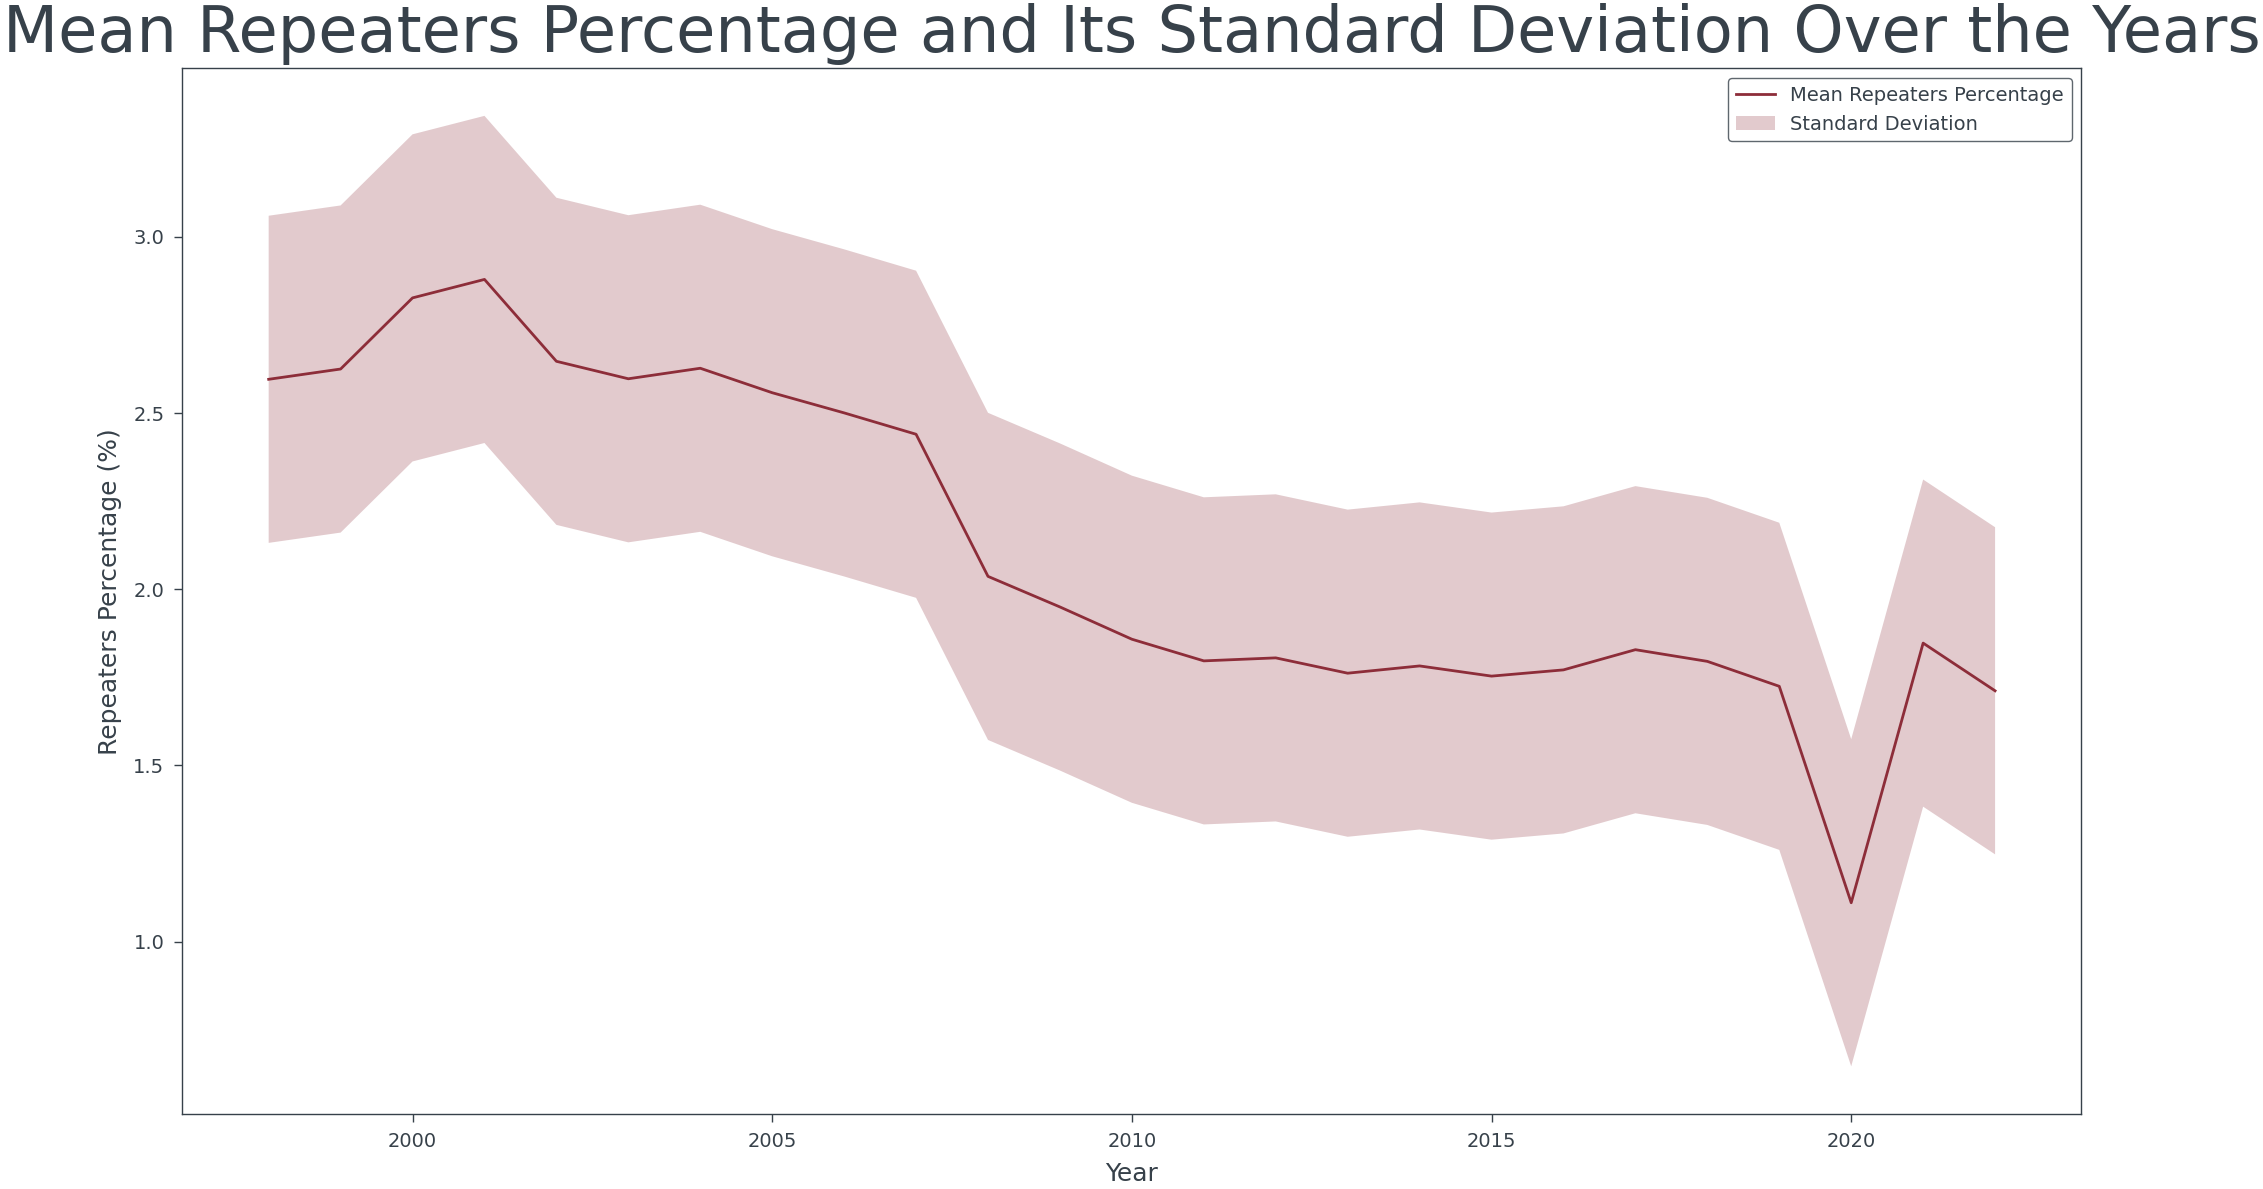

In [134]:
years_number_of_school_children_df = pd.DataFrame({
    'Year': years_number_of_school_children,
    'TotalPupils': numbe_of_school_children
})

import matplotlib.pyplot as plt

# Eindeutige Klassen aus dem DataFrame extrahieren
unique_classes = df_melted['class'].unique()

unique_years = df_melted['year'].unique()

mean_repeaters_per_year = pd.DataFrame(total_repeaters, columns=['Year', 'avg repeaters'])
mean_repeaters_per_year = mean_repeaters_per_year.set_index('Year')

total_pupils_per_year = years_number_of_school_children_df.groupby('Year').sum()

# Zusammenführen der Daten über Wiederholer und Gesamtschüleranzahl
merged_data = mean_repeaters_per_year.merge(
    total_pupils_per_year, left_index=True, right_index=True)

# Berechnung des Prozentsatzes der Wiederholer pro Jahr
merged_data['RepeatersPercentage'] = (merged_data['avg repeaters'] / merged_data['TotalPupils']) * 100

mean_repeaters_percentage = merged_data['RepeatersPercentage'] 

std_repeaters_percentage = mean_repeaters_percentage.std()

import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting the mean repeaters percentage
plt.plot(merged_data.index, mean_repeaters_percentage, label='Mean Repeaters Percentage')

# Adding standard deviation as filled area
plt.fill_between(merged_data.index,
                 mean_repeaters_percentage - std_repeaters_percentage,
                 mean_repeaters_percentage + std_repeaters_percentage,
                 alpha=0.25,
                 label='Standard Deviation')

# Adding title and labels
plt.title('Mean Repeaters Percentage and Its Standard Deviation Over the Years',fontsize=23)
plt.xlabel('Year')
plt.ylabel('Repeaters Percentage (%)')

# Showing the legend
plt.legend()

# Displaying the plot
plt.show()

